In [1]:
# PyTorch and Pyro imports
import torch
import zuko
import numpy as np
from torch import Size, Tensor
import pyro
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, PyroOptim, ClippedAdam
from pyro.infer.mcmc.mcmc_kernel import MCMCKernel
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.distributions.transforms import Spline, ComposeTransform
from pyro.distributions import TransformedDistribution

# Utility imports
import GPUtil
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import ARI, NMI

# Custom module imports
from xenium_cluster import XeniumCluster
from data import prepare_DLPFC_data, prepare_synthetic_data, prepare_Xenium_data
from zuko_flow import setup_zuko_flow

/home/roko/.cache/pypoetry/virtualenvs/diff-i93oUBlF-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ZukoToPyro(pyro.distributions.TorchDistribution):
    r"""Wraps a Zuko distribution as a Pyro distribution.

    If ``dist`` has an ``rsample_and_log_prob`` method, like Zuko's flows, it will be
    used when sampling instead of ``rsample``. The returned log density will be cached
    for later scoring.

    :param dist: A distribution instance.
    :type dist: torch.distributions.Distribution

    .. code-block:: python

        flow = zuko.flows.MAF(features=5)

        # flow() is a torch.distributions.Distribution

        dist = flow()
        x = dist.sample((2, 3))
        log_p = dist.log_prob(x)

        # ZukoToPyro(flow()) is a pyro.distributions.Distribution

        dist = ZukoToPyro(flow())
        x = dist((2, 3))
        log_p = dist.log_prob(x)

        with pyro.plate("data", 42):
            z = pyro.sample("z", dist)
    """

    def __init__(self, dist: torch.distributions.Distribution):
        self.dist = dist
        self.cache = {}

    @property
    def has_rsample(self) -> bool:
        return self.dist.has_rsample

    @property
    def event_shape(self) -> Size:
        return self.dist.event_shape

    @property
    def batch_shape(self) -> Size:
        return self.dist.batch_shape

    def __call__(self, shape: Size = ()) -> Tensor:
        if hasattr(self.dist, "rsample_and_log_prob"):  # fast sampling + scoring
            x, self.cache[x] = self.dist.rsample_and_log_prob(shape)
        # elif self.has_rsample:
        #     x = self.dist.rsample(shape)
        else:
            x = self.dist.sample(shape)

        return x

    def log_prob(self, x: Tensor) -> Tensor:
        if x in self.cache:
            return self.cache[x]
        else:
            return self.dist.log_prob(x)

    def expand(self, *args, **kwargs):
        return ZukoToPyro(self.dist.expand(*args, **kwargs))

# Potts Prior

The Potts prior is a prior distribution of cluster assignments given neighboring states. The general form of the Potts model is $$\pi(z_i) \propto \exp \left( \sum_i H(z_i) + \sum_{(i,j) \in G} J(z_i, z_j)\right)$$. H is the local potention representing some external influence of bias on the spot i. J is the interaction energy between neighboring sites. This represents the neighboring signals of spots, which is how we enforce the spatial clustering. The BayesSpace formulation feels like a more natural representation of this concept. $$\pi(z_i) \propto \exp \left( \frac{\gamma}{\langle ij \rangle} * 2\sum_{\langle ij \rangle} I(z_i = z_j)\right)$$ $\gamma$ is a smoothing parameter which can be tuned to increase the spatial contiguity of spatial assignments. 

In [3]:
class Potts2D(dist.Distribution):

    def __init__(self, current_state, batch_idx, num_clusters=7, radius=1, gamma=1.5):
        super().__init__()
        self.current_state = current_state
        self.batch_idx = batch_idx
        self.num_clusters = num_clusters
        self.radius = radius
        self.gamma = gamma
        self.num_rows, self.num_cols = current_state.shape

    @property
    def batch_shape(self):
        # The shape of the grid
        return torch.Size([len(self.batch_idx)])

    @property
    def event_shape(self):
        # No event dimensions (this is over the whole grid)
        return torch.Size([])

    def expand(self, batch_shape, _instance=None):
        # Create a new instance of Potts2D with the same parameters but a new batch shape
        new_instance = Potts2D(
            current_state=self.current_state,
            batch_idx=self.batch_idx,
            num_clusters=self.num_clusters,
            radius=self.radius,
            gamma=self.gamma,
        )
        return new_instance

    def __call__(self):
        return self.sample()

    def get_neighbors(self, i, j):
        neighbors = []
        for x in range(max(0, i - self.radius), min(self.current_state.shape[0], i + self.radius + 1)):
            for y in range(max(0, j - self.radius), min(self.current_state.shape[1], j + self.radius + 1)):
                if abs(x - i) + abs(y - j) <= self.radius:
                    neighbors.append((x, y))
        return neighbors

    def sample(self):
        num_rows, num_cols = self.current_state.shape

        new_state = self.current_state.clone() 
        new_soft_state = torch.zeros(new_state.size(0), new_state.size(1), self.num_clusters)
        
        for i in range(num_rows):
            for j in range(num_cols):
            # Compute conditional probabilities for site i
                probs = torch.zeros(self.num_clusters)
                for k in range(1, self.num_clusters + 1):
                    # Compute the contribution of neighbors
                    probs[k-1] = torch.sum(
                        torch.tensor(
                            [2 * self.gamma if new_state[a][b] == k else 0.0 for (a, b) in self.get_neighbors(i, j)]
                        )
                    )
                
                # Normalize to get valid probabilities
                probs = torch.exp(probs - torch.max(probs))  # Avoid numerical issues
                probs /= probs.sum()
                probs = torch.clamp(probs, min=0.0001)
                new_soft_state[i][j] = probs
                new_state[i][j] = torch.multinomial(probs, 1).item()

        self.current_state = new_state
        
        MIN_PROB = 0.01
        return torch.clamp(new_soft_state.reshape(-1, self.num_clusters)[self.batch_idx], min=MIN_PROB)

    def log_prob(self, cluster_probs):

        if cluster_probs.dim() == 2:

            cluster_state_flattened = self.current_state.reshape(-1,1)[self.batch_idx]

            # -1 is for indexing purposes. The 0 cluster is for empty cells.
            # print(cluster_probs.shape)
            # print(range(cluster_state_flattened.size(0)))
            # print(cluster_state_flattened.flatten() - 1)
            cluster_prob_tensor = cluster_probs[range(cluster_state_flattened.size(0)), cluster_state_flattened.flatten() - 1]

            log_prob_tensor = torch.log(cluster_prob_tensor)

        else:

            cluster_state_flattened = self.current_state.reshape(-1,1)[self.batch_idx]

            # -1 is for indexing purposes. The 0 cluster is for empty cells.
            cluster_prob_tensor = cluster_probs[:, range(cluster_state_flattened.size(0)), cluster_state_flattened.flatten() - 1]

            log_prob_tensor = torch.log(cluster_prob_tensor)

        return log_prob_tensor  # Return the sum of all values in log_prob_tensor

# Data Construction

We use the simulated dataset from the BayXenSmooth paper as an initial assessment of our idea. To make this happen we need to load in the data.

In [4]:
# Data Properties
batch_size = 256
data_dimension = 5
num_clusters = 7
learn_global_variances = False

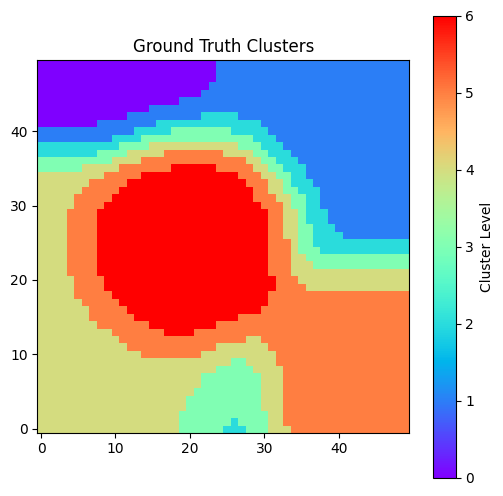

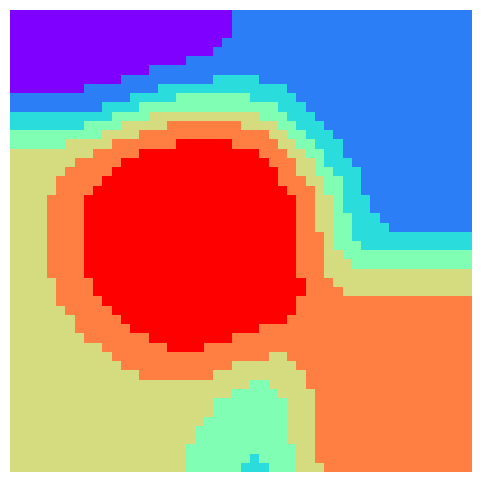

In [5]:
gene_data, spatial_locations, original_adata, TRUE_PRIOR_WEIGHTS = prepare_synthetic_data(num_clusters=num_clusters, data_dimension=data_dimension)
prior_means = torch.zeros(num_clusters, gene_data.shape[1])
prior_scales = torch.ones(num_clusters, gene_data.shape[1])

In [6]:
data = torch.tensor(gene_data).float()
num_obs, data_dim = data.shape

# Variational Inference

Objective: Given a Potts model for the prior and a GMM for the likelihood, how can we get a good posterior? 

In BayXenSmooth, we attempted to do this via an SVI framework where the posterior was approximated by another distribution with a desired paramteric form. This can be useful, but we want to model more complicated posteriors. This is where normalizing flows come in. By learning the posterior outcomes with complicated flows, we can plug in the flow as a variational distribution and train the variational inference procedure in a similar backprop way.

### Prior and Likelihood Calculations

Right now, we're re-using the old janky empirical prior that BayXenSmooth used. Eventually, the Potts model will be integrated. For now, the objective is to see how spatially contiguous spatial clusters look.

In [7]:
# Global Params to Set
neighborhood_size = 1
neighborhood_agg = "mean"
num_pcs = 3

def custom_cluster_initialization(original_adata, method, K=17):

    original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

    # This function initializes clusters based on the specified method
    if method == "K-Means":
        initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=False, K=K, include_spatial=False)
    elif method == "Hierarchical":
        initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, num_clusters=K)
    elif method == "Leiden":
        initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.35], save_plot=False, K=K)[0.35]
    elif method == "Louvain":
        initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[0.35], save_plot=False, K=K)[0.35]
    elif method == "mclust":
        original_adata.pca(original_adata.xenium_spot_data, num_pcs)
        initial_clusters = original_adata.mclust(original_adata.xenium_spot_data, G=K, model_name = "EEE")
    elif method == "random":
        initial_clusters = np.random.randint(0, K, size=original_adata.xenium_spot_data.X.shape[0])
    else:
        raise ValueError(f"Unknown method: {method}")

    return initial_clusters

/home/roko/.cache/pypoetry/virtualenvs/diff-i93oUBlF-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/roko/diff/nf/xenium_cluster.py:393: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rows = torch.tensor(data.obs["row"].astype(int))
/home/roko/diff/nf/xenium_cluster.py:394: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cols = torch.tensor(data.obs["col"].astype(int))
/home/roko

K-Means Metrics:  {'ARI': 0.79, 'NMI': 0.8}


100%|██████████| 2500/2500 [00:00<00:00, 29756.29it/s]
/tmp/ipykernel_1844318/1352025234.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_grid_PRIOR[rows, columns] = cluster_assignments_prior + 1
/tmp/ipykernel_1844318/1352025234.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters)


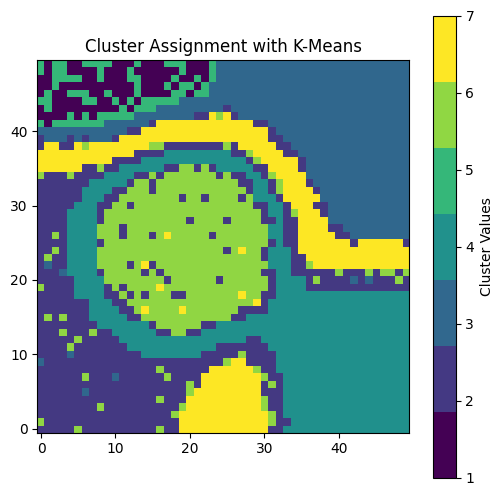

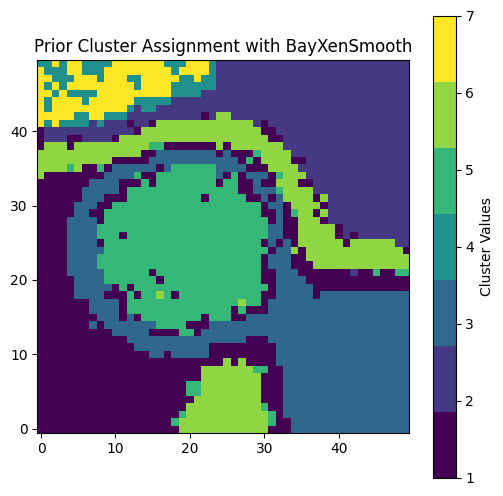

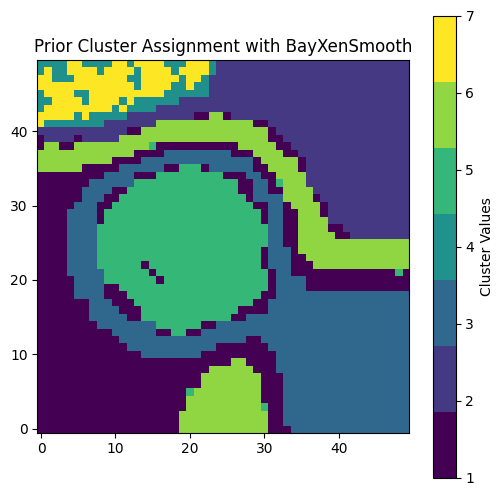

In [8]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial import KDTree

# Clamping
MIN_CONCENTRATION = 0.01

num_posterior_samples = 10

spatial_init_data = StandardScaler().fit_transform(gene_data)
gene_data = StandardScaler().fit_transform(gene_data)
empirical_prior_means = torch.zeros(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

initial_clusters = custom_cluster_initialization(original_adata, "K-Means", K=num_clusters)

ari = ARI(initial_clusters, TRUE_PRIOR_WEIGHTS.argmax(axis=-1))
nmi = NMI(initial_clusters, TRUE_PRIOR_WEIGHTS.argmax(axis=-1))
cluster_metrics = {
    "ARI": round(ari, 2),
    "NMI": round(nmi, 2)
}
print("K-Means Metrics: ", cluster_metrics)

for i in range(num_clusters):
    cluster_data = gene_data[initial_clusters == i]
    if cluster_data.size > 0:  # Check if there are any elements in the cluster_data
        empirical_prior_means[i] = torch.tensor(cluster_data.mean(axis=0))
        empirical_prior_scales[i] = torch.tensor(cluster_data.std(axis=0))
cluster_probs_prior = torch.zeros((initial_clusters.shape[0], num_clusters))
cluster_probs_prior[torch.arange(initial_clusters.shape[0]), initial_clusters - 1] = 1.

locations_tensor = torch.tensor(spatial_locations.to_numpy())

# Compute the number of elements in each dimension
num_spots = cluster_probs_prior.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_cluster_probs_prior = torch.zeros_like(cluster_probs_prior, dtype=torch.float64)

spot_locations = KDTree(locations_tensor.cpu())  # Ensure this tensor is in host memory
neighboring_spot_indexes = spot_locations.query_ball_point(locations_tensor.cpu(), r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = cluster_probs_prior[neighboring_spot_indexes[i]]

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "mean":
        neighborhood_priors = priors_in_neighborhood.mean(dim=0)
    else:
        locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
        neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
        distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
        def distance_weighting(x):
            weight = 1/(1 + x/1)
            # print(weight)
            return weight / weight.sum()
        neighborhood_priors = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
    # Update the cluster probabilities
    spatial_cluster_probs_prior[i] += neighborhood_priors

spatial_cluster_probs_prior = spatial_cluster_probs_prior.clamp(MIN_CONCENTRATION)
sample_for_assignment_options = [True, False]

num_prior_samples = 10
for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_assignments_prior_TRUE = pyro.sample("cluster_assignments", dist.Categorical(spatial_cluster_probs_prior).expand_by([num_prior_samples])).detach().mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_assignments_prior_FALSE = spatial_cluster_probs_prior.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid_PRIOR = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid_PRIOR[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid_PRIOR.cpu(), cmap=colors, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(1, num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

In [9]:
torch.set_printoptions(sci_mode=False)
NUM_PARTICLES = 5

expected_total_param_dim = 2 # K x D
cluster_states = cluster_grid_PRIOR.clone()

def model(data):

    global cluster_states

    with pyro.plate("clusters", num_clusters):

        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(prior_means, 10.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(prior_scales, 10.0).to_event(1))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        
        prior_dist = Potts2D(cluster_states, ind, radius=neighborhood_size, num_clusters=num_clusters)
        cluster_probs = pyro.sample("cluster_probs", prior_dist)
        cluster_states = prior_dist.current_state
        # likelihood for batch
        if cluster_means.dim() == expected_total_param_dim:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), 
                    torch.log(cluster_probs)
                ), 
                obs=batch_data
            )
        # likelihood for batch WITH vectorization of particles
        else:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    torch.log(cluster_probs)
                ), 
                obs=batch_data
            )

### Variational Guide

In [12]:
cluster_probs_flow_dist = setup_zuko_flow(
    flow_type="CNF",
    flow_length=32,
    num_clusters=num_clusters,
    context_length=data_dim,
    hidden_layers=(128, 128, 128)
)
cluster_probs_flow_dist.transform.ode.append(torch.nn.Softmax(dim=-1))

# orders = [
#     torch.arange(num_clusters),
#     torch.arange(num_clusters),
#     torch.flipud(torch.arange(num_clusters)),
#     torch.flipud(torch.arange(num_clusters)),
# ]


# cluster_probs_flow_dist = zuko.flows.Flow(
#     transform=[
#             zuko.flows.MaskedAutoregressiveTransform(
#                 features=num_clusters,
#                 context=data_dim,
#                 order=orders[i % 4],
#             ) if i % 2 == 0 else zuko.lazy.UnconditionalTransform(lambda: zuko.transforms.SoftclipTransform(bound=100.0))
#             for i in range(32)
#         ],
#     base=cluster_probs_flow_dist.base  # Base distribution stays the same
# )  

def guide(data):
    
    pyro.module("posterior_flow", cluster_probs_flow_dist)

    with pyro.plate("clusters", num_clusters):
        # Global variational parameters for cluster means and scales
        cluster_means_q_mean = pyro.param("cluster_means_q_mean", prior_means + torch.randn_like(prior_means) * 0.05)
        cluster_scales_q_mean = pyro.param("cluster_scales_q_mean", prior_scales + torch.randn_like(prior_scales) * 0.01, constraint=dist.constraints.positive)
        if learn_global_variances:
            cluster_means_q_scale = pyro.param("cluster_means_q_scale", torch.ones_like(prior_means) * 1.0, constraint=dist.constraints.positive)
            cluster_scales_q_scale = pyro.param("cluster_scales_q_scale", torch.ones_like(prior_scales) * 0.25, constraint=dist.constraints.positive)
            cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, cluster_means_q_scale).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, cluster_scales_q_scale).to_event(1))
        else:
            cluster_means = pyro.sample("cluster_means", dist.Delta(cluster_means_q_mean).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.Delta(cluster_scales_q_mean).to_event(1))

    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]

        cluster_logits = pyro.sample("cluster_logits", ZukoToPyro(cluster_probs_flow_dist(batch_data)), infer={'is_auxiliary': True})
        print(cluster_logits)
        print(cluster_probs_flow_dist)
        1/0
        temperature = pyro.param(
            "temperature",
            torch.tensor(1.0),
            constraint=dist.constraints.interval(0.01, 10.0),
        )
        # Print a 5 number summary of the cluster_logits
        # summary = torch.quantile(cluster_logits, torch.tensor([0, 0.25, 0.5, 0.75, 1]))
        # print("5 number summary of cluster_logits: ", summary)


        # Make the logits numerically stable
        max_logit = torch.max(cluster_logits, dim=-1, keepdim=True).values
        stable_logits = cluster_logits - max_logit

        # Sample cluster_probs using RelaxedOneHotCategorical
        # Calculate and print a 5 number summary of the batch data
        cluster_probs = pyro.sample(
            "cluster_probs",
            dist.RelaxedOneHotCategorical(temperature=temperature, logits=stable_logits, validate_args=False)
        )


# Training the Model

In [13]:
pyro.clear_param_store()
NUM_EPOCHS = 100
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

def per_param_callable(param_name):
    if param_name == 'cluster_means_q_mean':
        return {"lr": 0.001, "betas": (0.9, 0.999), "clip_norm": 5.0}
    elif param_name == 'cluster_scales_q_mean':
        return {"lr": 0.001, "betas": (0.9, 0.999), "clip_norm": 5.0}
    elif "logit" in param_name:
        return {"lr": 0.0001, "betas": (0.9, 0.999), "clip_norm": 5.0}
    else:
        return {"lr": 0.0001, "betas": (0.9, 0.999), "clip_norm": 5.0}

# scheduler = Adam(per_param_callable)
scheduler = ClippedAdam(per_param_callable)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

epoch_pbar = tqdm(range(NUM_EPOCHS))
PATIENCE = 25
current_min_loss = float('inf')
patience_counter = 0
for epoch in range(1, NUM_EPOCHS + 1):
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
    epoch_pbar.set_description(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
    # print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
    if running_loss > current_min_loss:
        patience_counter += 1
    else:
        current_min_loss = running_loss
        patience_counter = 0
    if patience_counter >= PATIENCE:
        break 

  0%|          | 0/100 [00:38<?, ?it/s]


tensor([[ 0.1224,  1.7540,  1.2484,  ...,  0.5804, -0.4711,  1.8981],
        [-1.5914, -0.2059, -0.0501,  ..., -0.1103,  0.6527,  0.3733],
        [-0.5149, -1.4973, -1.1166,  ...,  0.2974,  0.8620,  0.3314],
        ...,
        [-2.0074,  0.1749,  0.4575,  ...,  0.4179, -0.2238, -0.8521],
        [ 1.1809, -1.5373, -1.3840,  ..., -0.6635,  2.1345, -1.0213],
        [-0.0222,  0.8818,  0.0832,  ..., -0.2379, -0.2518, -0.1046]],
       grad_fn=<SqueezeBackward1>)
CNF(
  (transform): FFJTransform(
    (ode): MLP(
      (0): Linear(in_features=18, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Tanh()
      (6): Linear(in_features=128, out_features=7, bias=True)
      (7): Softmax(dim=-1)
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: torch.Size([7]), scale: torch.Size([7])))
)


ZeroDivisionError: division by zero

# Saving Model Results to Infinite Memory Folder

In [17]:
import os

save_path = os.path.join("/nfs/turbo/lsa-regier/scratch", "roko/nf_results", "test_model")

In [18]:
pyro.get_param_store().save(save_path)

In [ ]:
pyro.get_param_store().load(save_path)

In [ ]:
pyro.get_param_store()

Note that should you decide to load a model, you will need to recreate the module with updated parameters as show in the cell below.

In [ ]:
num_posterior_samples = 10
cluster_probs_samples = []

pyro.module("posterior_flow", cluster_probs_flow_dist, update_module_params=True)

for _ in range(num_posterior_samples):
    with pyro.plate("data", len(data)):
        cluster_logits = pyro.sample("cluster_logits", ZukoToPyro(cluster_probs_flow_dist(data)), infer={'is_auxiliary': True})
        temperature = pyro.param("temperature")

        # Make the logits numerically stable
        max_logit = torch.max(cluster_logits, dim=-1, keepdim=True).values
        stable_logits = cluster_logits - max_logit

        # Sample cluster_probs using RelaxedOneHotCategorical
        # Calculate and print a 5 number summary of the batch data
        cluster_probs_sample = pyro.sample(
            "cluster_probs",
            dist.RelaxedOneHotCategorical(temperature=temperature, logits=stable_logits, validate_args=False)
        )
    cluster_probs_samples.append(cluster_probs_sample)
print("The final temperature was ", temperature)
cluster_probs_avg = torch.stack(cluster_probs_samples).mean(dim=0)
cluster_assignments_posterior = cluster_probs_avg.argmax(dim=-1)

In [ ]:
# KL Calculation
CLAMP = 0.000001
spatial_cluster_probs_prior = spatial_cluster_probs_prior.cpu().detach().clamp(CLAMP)
TRUE_WEIGHTS = torch.tensor(TRUE_PRIOR_WEIGHTS).clamp(CLAMP)
kl_prior_divergence = torch.sum(TRUE_WEIGHTS * torch.log(TRUE_WEIGHTS / spatial_cluster_probs_prior), dim=1)
kl_post_divergence = torch.sum(TRUE_WEIGHTS * torch.log(TRUE_WEIGHTS / cluster_probs_avg), dim=1)
kl_prior_divergence.mean(), kl_post_divergence.mean()

In [26]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

prior_cm = confusion_matrix(TRUE_WEIGHTS.argmax(dim=-1), cluster_assignments_prior)
posterior_cm = confusion_matrix(TRUE_WEIGHTS.argmax(dim=-1), cluster_assignments_posterior)

_, prior_permutation = linear_sum_assignment(cost_matrix = prior_cm, maximize=True)
_, posterior_permutation = linear_sum_assignment(cost_matrix = posterior_cm, maximize=True)

# verify that the labelling doesn't magically switch during the learning process
assert np.all(prior_permutation == posterior_permutation)
permutation = prior_permutation

In [ ]:
# Recalculate KL on the permuted inferred values.
CLAMP = 0.000001
spatial_cluster_probs_prior = spatial_cluster_probs_prior.cpu().detach().clamp(CLAMP)
TRUE_WEIGHTS = torch.tensor(TRUE_PRIOR_WEIGHTS).clamp(CLAMP)
kl_prior_divergence = torch.sum(TRUE_WEIGHTS * torch.log(TRUE_WEIGHTS / spatial_cluster_probs_prior[:, permutation]), dim=1)
kl_post_divergence = torch.sum(TRUE_WEIGHTS * torch.log(TRUE_WEIGHTS / cluster_probs_avg[:, permutation]), dim=1)
print(kl_prior_divergence.mean(), kl_post_divergence.mean())

In [ ]:
index = 25
TRUE_WEIGHTS[index], spatial_cluster_probs_prior[index], spatial_cluster_probs_prior[:, permutation][index], cluster_probs_avg[index], cluster_probs_avg[:, permutation][index]

In [ ]:
torch.sum(TRUE_WEIGHTS * torch.log(TRUE_WEIGHTS / cluster_probs_avg[:, permutation]), dim=1)

In [ ]:
prior_KL_grid = torch.zeros(num_rows, num_cols, dtype=float)
prior_KL_grid[rows, columns] = kl_prior_divergence
cmap = plt.cm.get_cmap('coolwarm')
plt.imshow(prior_KL_grid.detach().numpy(), origin='lower', cmap=cmap)
plt.colorbar(label='KL Divergence')
plt.title("KL on Prior Distribution")

In [ ]:
posterior_KL_grid = torch.zeros(num_rows, num_cols, dtype=float)
posterior_KL_grid[rows, columns] = kl_post_divergence
cmap = plt.cm.get_cmap('coolwarm')
plt.imshow(posterior_KL_grid.detach().numpy(), origin='lower', cmap=cmap)
plt.colorbar(label='KL Divergence')
plt.title("KL on Posterior Distribution")

In [ ]:
rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = cluster_assignments_posterior + 1

colors = plt.cm.get_cmap('viridis', num_clusters + 1)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid.cpu(), cmap=colors, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(1, num_clusters + 1), label='Cluster Values')
plt.title('Posterior Cluster Assignment with XenNF')

ari = ARI(cluster_assignments_posterior, TRUE_PRIOR_WEIGHTS.argmax(axis=-1))
nmi = NMI(cluster_assignments_posterior, TRUE_PRIOR_WEIGHTS.argmax(axis=-1))
cluster_metrics = {
    "ARI": round(ari, 2),
    "NMI": round(nmi, 2)
}
print(cluster_metrics)